#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Embedding
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


#### loading and displaying the datasets

In [3]:

train_data = pd.read_csv('SQLIV3_cleaned2.csv')
test_data = pd.read_csv('sqliv2_utf8.csv')
print(train_data)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


#### Remove duplicates from train and test sets.


In [4]:

train_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)
test_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)


#### 'Label' Data Distribution


C:\Users\DELL\AppData\Local\Temp\ipykernel_10116\2877702203.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)
C:\Users\DELL\AppData\Local\Temp\ipykernel_10116\2877702203.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)


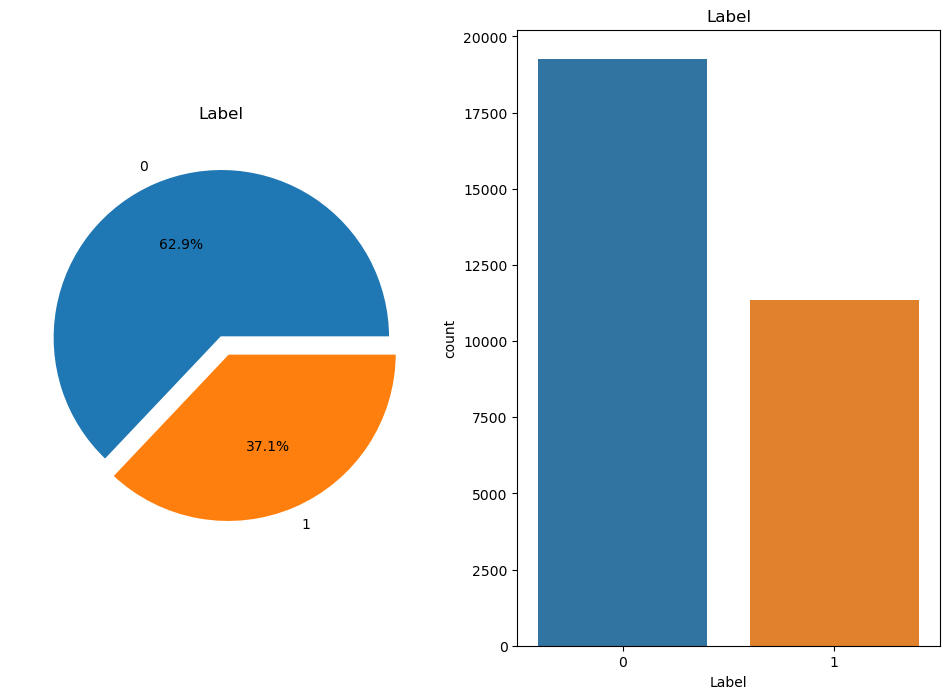

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train_data['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

#### Tokenization (keeping all characters)


In [ ]:

vocab_size = 15000
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters='',
    lower=True
)
tokenizer.fit_on_texts(train_data['Sentence'])

#### Adaptive Padding

In [7]:

max_len = int(np.percentile([len(x.split()) for x in train_data['Sentence']], 95))
X = tokenizer.texts_to_sequences(train_data['Sentence'])
X = pad_sequences(X, padding='post', maxlen=max_len)
y = train_data['Label'].astype('int')


#### Train/Validation Split


In [8]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16, shuffle=True)

#### Model Architecture

In [10]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SimpleRNN(128, return_sequences=False),  
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])


#### Model Compilation with Early Stopping and Adam Optimizer


In [11]:

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Model Training

In [12]:

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
383/383 [==============================] - 35s 81ms/step - loss: 0.8136 - accuracy: 0.9643 - val_loss: 0.5745 - val_accuracy: 0.9925
Epoch 2/20
383/383 [==============================] - 28s 73ms/step - loss: 0.4575 - accuracy: 0.9919 - val_loss: 0.3430 - val_accuracy: 0.9935
Epoch 3/20
383/383 [==============================] - 21s 56ms/step - loss: 0.2788 - accuracy: 0.9917 - val_loss: 0.2043 - val_accuracy: 0.9941
Epoch 4/20
383/383 [==============================] - 21s 56ms/step - loss: 0.6802 - accuracy: 0.7051 - val_loss: 0.7650 - val_accuracy: 0.6258
Epoch 5/20
383/383 [==============================] - 27s 70ms/step - loss: 0.3248 - accuracy: 0.9133 - val_loss: 0.2062 - val_accuracy: 0.9688
Epoch 6/20
383/383 [==============================] - 22s 57ms/step - loss: 0.2112 - accuracy: 0.9641 - val_loss: 0.1939 - val_accuracy: 0.9650
Epoch 7/20
383/383 [==============================] - 20s 53ms/step - loss: 0.1870 - accuracy: 0.9656 - val_loss: 0.1003 - val_accuracy:

In [13]:
print("Final Training Loss:", history.history['loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])

Final Training Loss: 0.048824600875377655
Final Training Accuracy: 0.9919525980949402


192/192 [==============================] - 3s 13ms/step
Accuracy: 0.990686274509804
Precision: 1.0
Recall: 0.9751
F1 Score: 0.9874

Classification Report:
                precision    recall  f1-score   support

Non-injection       0.99      1.00      0.99      3830
    Injection       1.00      0.98      0.99      2290

     accuracy                           0.99      6120
    macro avg       0.99      0.99      0.99      6120
 weighted avg       0.99      0.99      0.99      6120



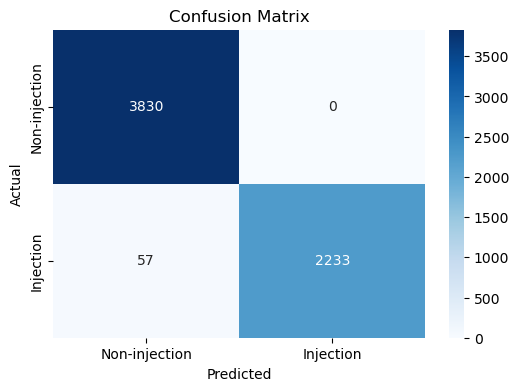

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions sur X_val
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Évaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Affichage
print("Accuracy:", accuracy)
print("Precision:", precision)
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=['Non-injection', 'Injection']))

# Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-injection', 'Injection'],
            yticklabels=['Non-injection', 'Injection'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Plotting Loss and Accuracy over Epochs


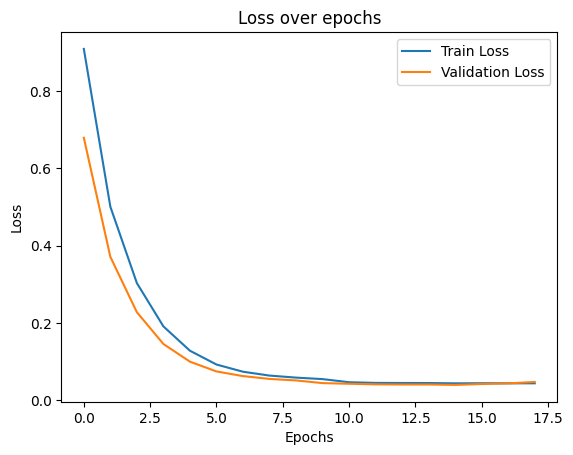

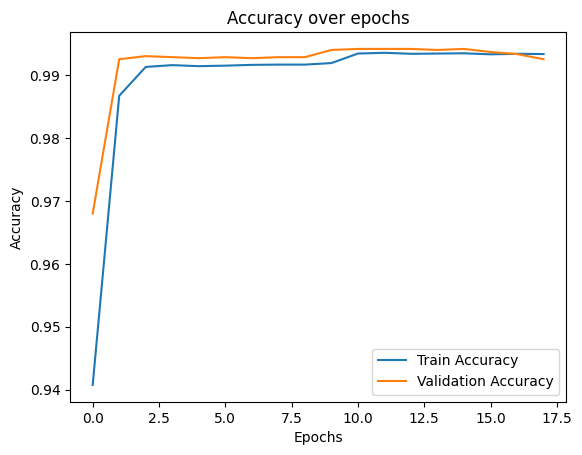

In [411]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Évaluation

In [412]:

test_data['Sentence'] = test_data['Sentence'].astype(str).fillna('')
X_test = tokenizer.texts_to_sequences(test_data['Sentence'])
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
test_loss, test_accuracy = model.evaluate(X_test, test_data['Label'].astype('int'))
print(f'\nTest Accuracy: {test_accuracy:.4f}')

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9712 - loss: 0.1477

Test Accuracy: 0.9901


#### Filter Only SQL Injection (Label = 1)


In [413]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

sqli_only = test_data[test_data['Label'] == 1].copy()

print(f"\n📌 total number of SQL injection in the test set : {len(sqli_only)}")


📌 total number of SQL injection in the test set : 11424


#### Preprocessing SQL Injection Sentences


In [ ]:

X_sqli = tokenizer.texts_to_sequences(sqli_only['Sentence'])
X_sqli = pad_sequences(X_sqli, padding='post', maxlen=max_len)

#### Prediction and Metrics Evaluation


In [415]:

y_true = sqli_only['Label'].astype(int).values
y_pred_prob = model.predict(X_sqli)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


print("\n📊 Evaluation on the SQL injection (Label = 1):")
print(f"✅ Accuracy : {accuracy_score(y_true, y_pred) * 100:.2f}%")
print(f"✅ Precision : {precision_score(y_true, y_pred, zero_division=0) * 100:.2f}%")
print(f"✅ Recall : {recall_score(y_true, y_pred, zero_division=0) * 100:.2f}%")
print(f"✅ F1 Score : {f1_score(y_true, y_pred, zero_division=0) * 100:.2f}%")


357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Evaluation on the SQL injection (Label = 1):
✅ Accuracy : 98.34%
✅ Precision : 100.00%
✅ Recall : 98.34%
✅ F1 Score : 99.16%


#### Filter Only Normal Queries (Label = 0)


In [416]:

normal_only = test_data[test_data['Label'] == 0].copy()

print(f"\n📌 total number of normal query in the test set : {len(normal_only)}")



📌 total number of normal query in the test set : 22302


#### Preprocessing Normal Queries Sentences


In [417]:

X_normal = tokenizer.texts_to_sequences(normal_only['Sentence'])
X_normal = pad_sequences(X_normal, padding='post', maxlen=max_len)

#### Prediction and Metrics Evaluation


In [418]:

y_true_normal = normal_only['Label'].astype(int).values
y_pred_prob_normal = model.predict(X_normal)
y_pred_normal = (y_pred_prob_normal > 0.5).astype(int).flatten()

print("\n📊 Evaluation on normal (Label = 0):")
print(f"✅ Accuracy : {accuracy_score(y_true_normal, y_pred_normal) * 100:.2f}%")
print(f"✅ Precision : {precision_score(y_true_normal, y_pred_normal, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ Recall : {recall_score(y_true_normal, y_pred_normal, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ F1 Score : {f1_score(y_true_normal, y_pred_normal, pos_label=0, zero_division=0) * 100:.2f}%")

697/697 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📊 Evaluation on normal (Label = 0):
✅ Accuracy : 99.35%
✅ Precision : 100.00%
✅ Recall : 99.35%
✅ F1 Score : 99.68%


In [419]:
model.save('/content/drive/MyDrive/models/rnn.h5')
